In [21]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
from math import * 

print("The current directory is: ")
print(os.getcwd())
if not os.getcwd().endswith("Abaqus-Hardening-Seq-2-Seq-Project"):
    # Move up two directories
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
print("The current directory is: ")
print(os.getcwd())

The current directory is: 
c:\Users\springnuance\Desktop\Abaqus-Hardening-Seq-2-Seq-Project
The current directory is: 
c:\Users\springnuance\Desktop\Abaqus-Hardening-Seq-2-Seq-Project


In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from configs.chosen_project import *
from src.stage1_global_configs import *

chosen_project_path = "configs/global_config_CP1000_RD_20C.json"

global_configs = main_global_configs(chosen_project_path)

all_paths = global_configs['all_paths']
objectives = global_configs['objectives']


= Stage 1: Loading configs and all paths =

Welcome to Abaqus Seq2Seq flow curve calibration project

The configurations you have chosen: 

+--------------------------+------------------------------------------------------------------+
|      Global Configs      |                           User choice                            |
+--------------------------+------------------------------------------------------------------+
|         PROJECT          |                          CP1000_RD_20C                           |
|        OBJECTIVES        |        CHD2, CHD4, NDBR2p5, NDBR6, NDBR15, NDBR40, SH115         |
|       PROJECT_PATH       | c:\Users\springnuance\Desktop\Abaqus-Hardening-Seq-2-Seq-Project |
|    TRAINING_DATA_PATH    |                   training_data/CP1000_RD_20C                    |
|         LOG_PATH         |                        log/CP1000_RD_20C                         |
|       MODELS_PATH        |                       models/CP1000_RD_20C                    

### Plotting initial FD curves

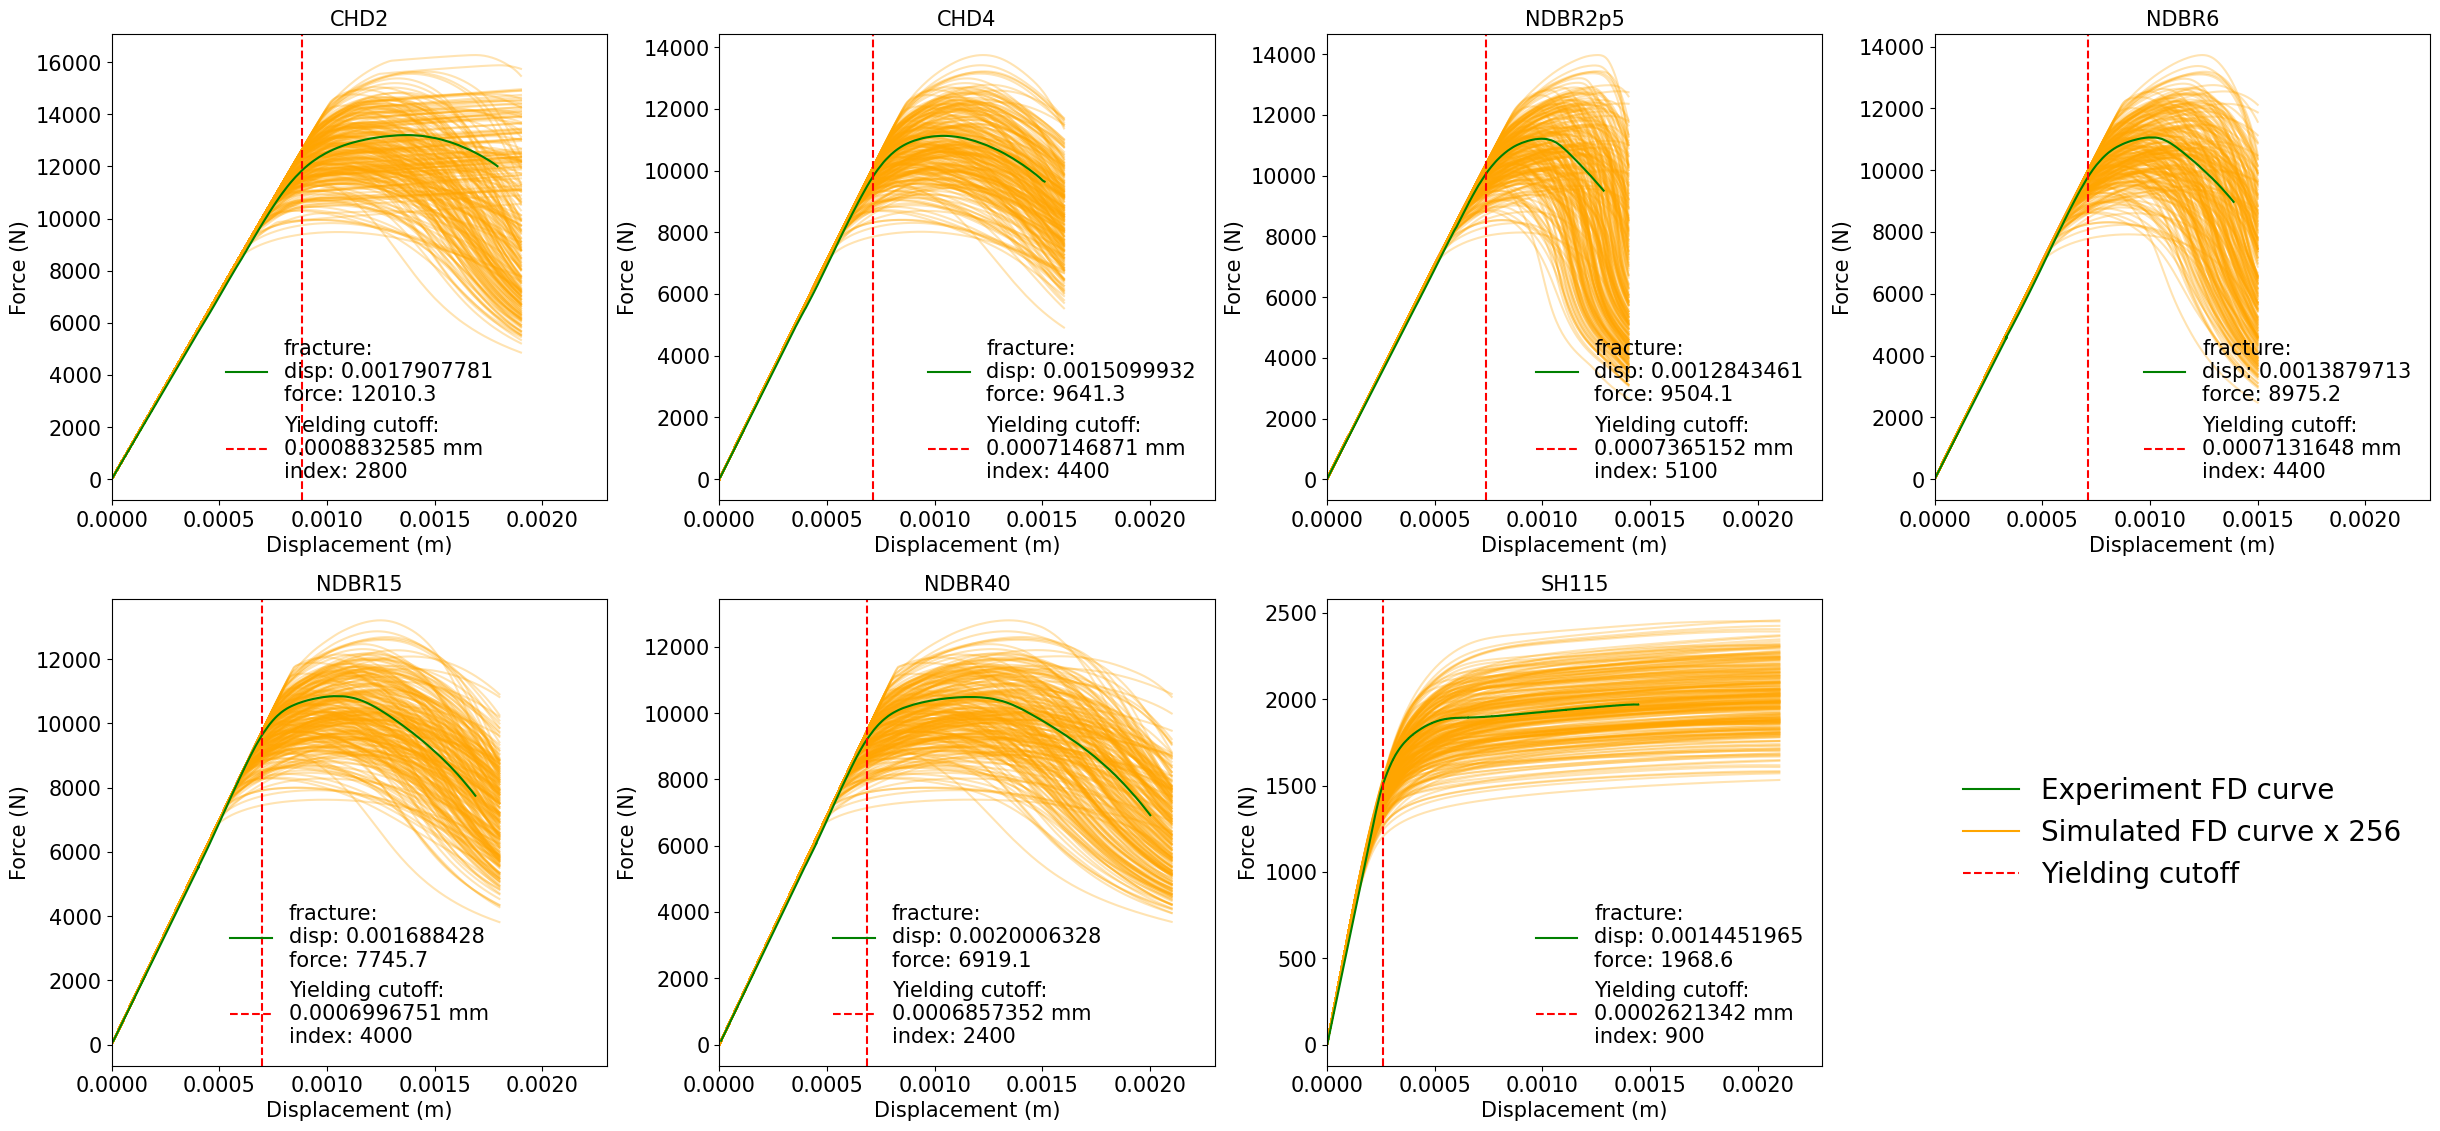

In [24]:
results_init_common_path = all_paths["results_init_common_path"]
targets_path = all_paths["targets_path"]

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25, 12))
fig.tight_layout(pad=5.0)
ax = ax.ravel()

exp_yielding_index = global_configs["exp_yielding_index"] 

for i, objective in enumerate(objectives):

    if os.path.exists(f"{results_init_common_path}/{objective}/FD_curves.npy"):
        # Plotting the mean simulated FD curve
        FD_curves = np.load(f"{results_init_common_path}/{objective}/FD_curves.npy", allow_pickle=True).tolist()
        for params_tuple, FD_curve in FD_curves.items():
            sim_displacement = FD_curve['displacement'] # displacement is in m
            sim_force = FD_curve['force']
            ax[i].plot(sim_displacement, sim_force, color='orange', alpha=0.3)
    
    # Plotting the mean experimental FD curve
    FD_curve_final = pd.read_excel(f"{targets_path}/{objective}/FD_curve_final.xlsx", engine='openpyxl')
    exp_displacement = FD_curve_final['displacement/m']
    exp_force = FD_curve_final['force/N']
    fracture_disp = exp_displacement.iloc[-1]
    fracture_force = exp_force.iloc[-1]
    fracture_disp = round(fracture_disp, 10)
    fracture_force = round(fracture_force, 1)

    ax[i].plot(exp_displacement, exp_force, label=f"fracture:\ndisp: {fracture_disp}\nforce: {fracture_force}",
               color='green')
    
    yielding_index = exp_yielding_index[objective]
    ax[i].axvline(x = exp_displacement[yielding_index], color='r', linestyle='--', 
                  label=f"Yielding cutoff:\n{round(exp_displacement[yielding_index], 10)} mm\nindex: {yielding_index}")

    ax[i].set_title(f"{objective}", fontsize=15)
    ax[i].set_xlabel("Displacement (m)", fontsize=15)
    ax[i].set_ylabel("Force (N)", fontsize=15)
    ax[i].set_xlim(0, 0.0023)
    #ax[i].set_ylim(-500, 17000)
    ax[i].set_xticks([0.0, 0.0005, 0.001, 0.0015, 0.002])
    # set fontsize for x and y ticks
    ax[i].xaxis.set_tick_params(labelsize=15)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(frameon=False, fontsize=15)

ax[7].axis('off')
ax[7].plot([],[],color="green", label="Experiment FD curve", alpha=1)
ax[7].plot([],[],color="orange", label=f"Simulated FD curve x {len(FD_curves)}", alpha=1)
ax[7].plot([],[],color="red", label="Yielding cutoff", linestyle='--')
ax[7].legend(frameon=False, fontsize=20,loc='center')

plt.show()

### Plot only one simulation 

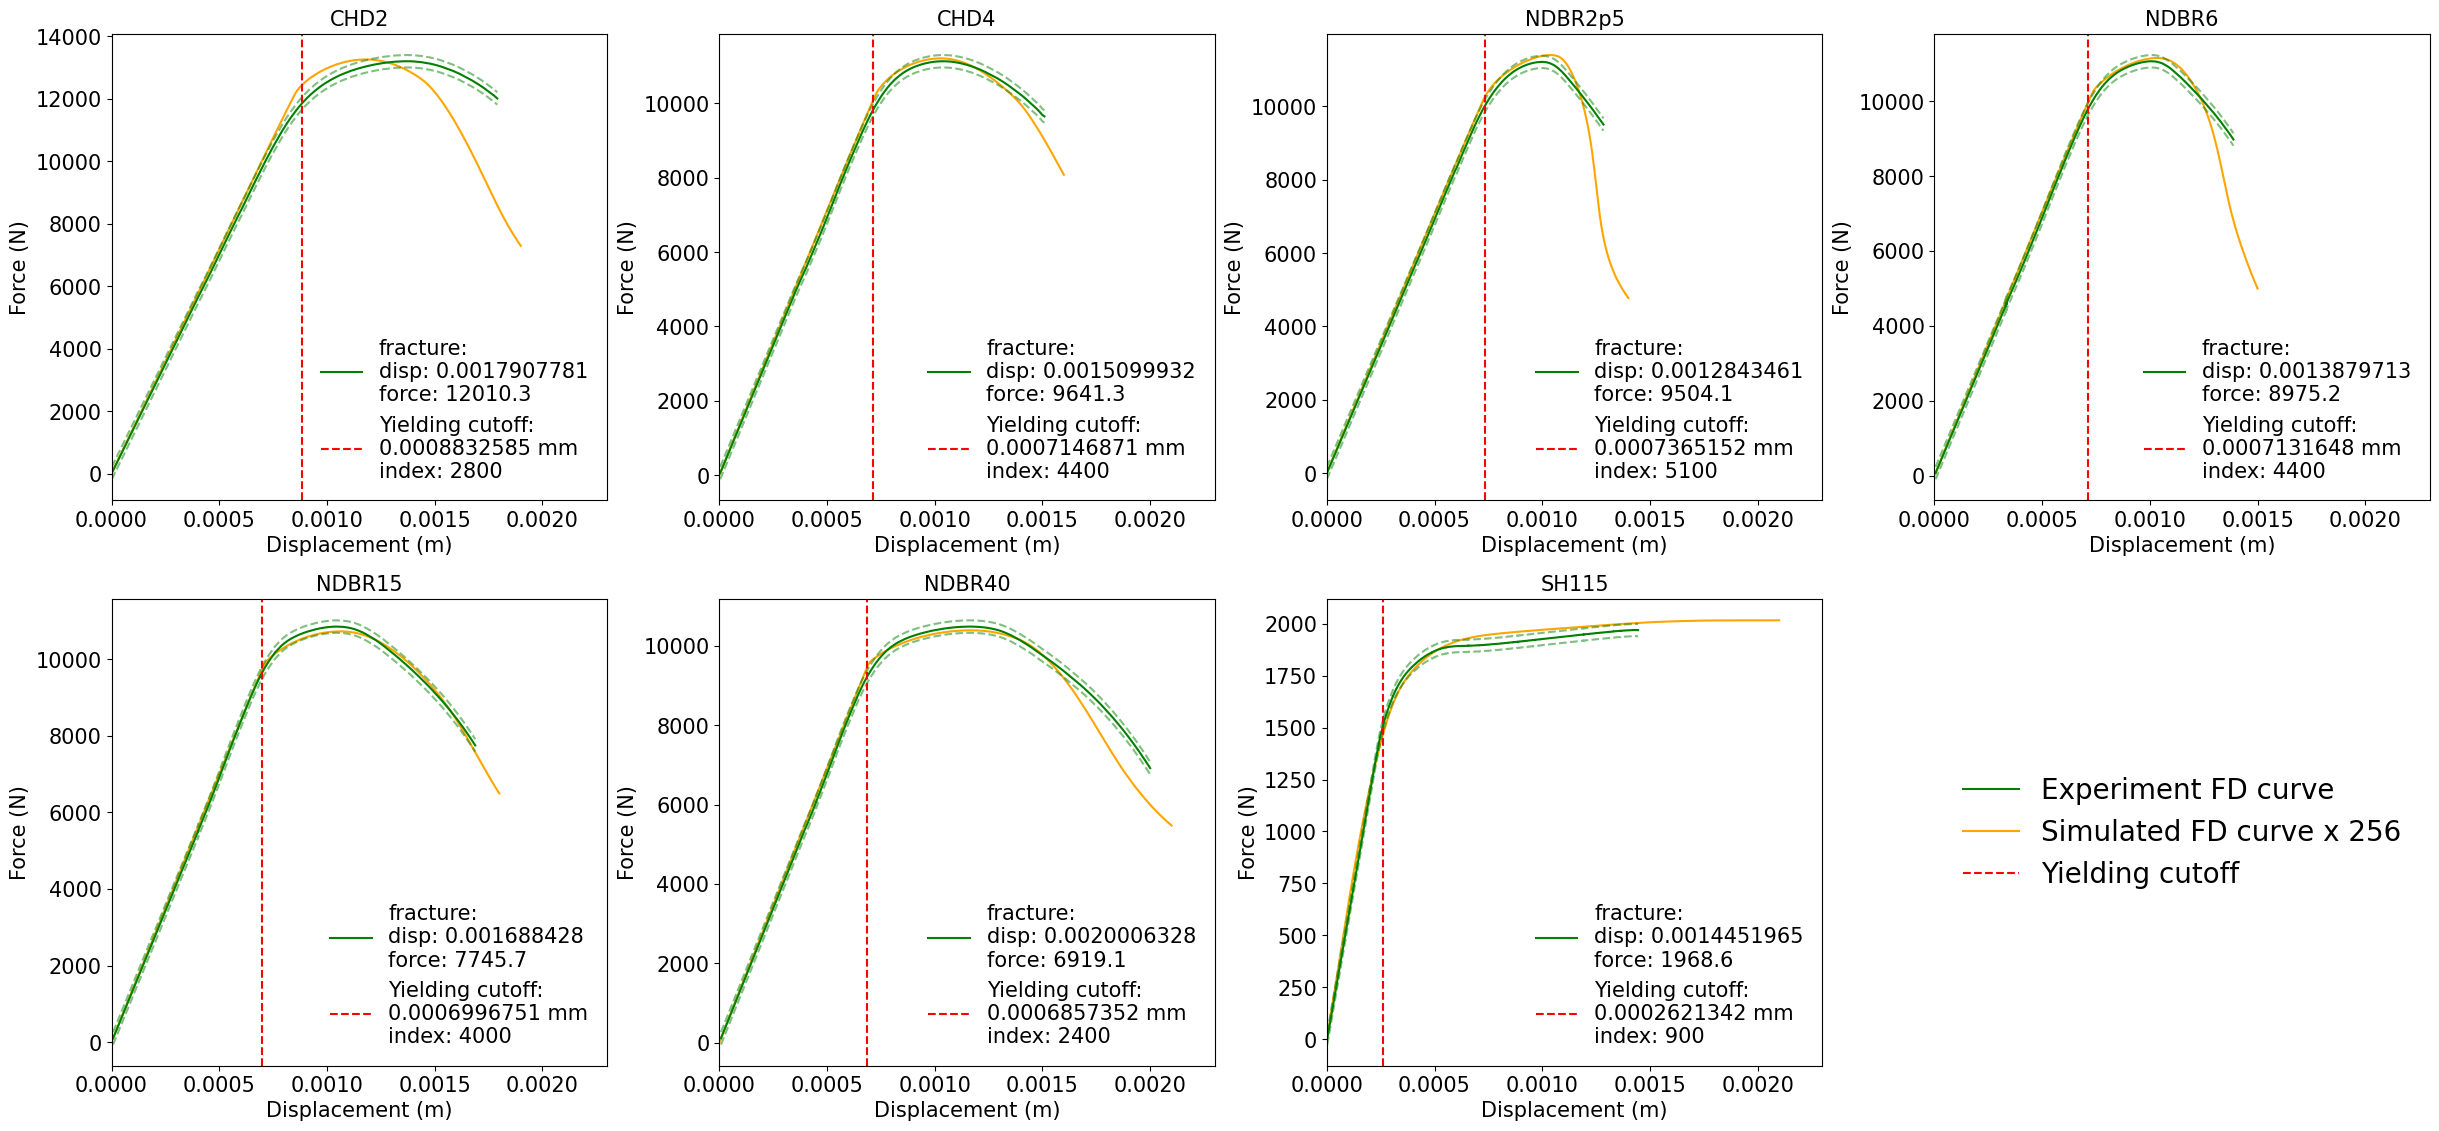

In [35]:
results_init_common_path = all_paths["results_init_common_path"]
targets_path = all_paths["targets_path"]

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25, 12))
fig.tight_layout(pad=5.0)
ax = ax.ravel()

exp_yielding_index = global_configs["exp_yielding_index"] 

chosen_sim_index = 181

stop_loss_config = global_configs['stop_loss_config']

stop_value_deviation_percent = stop_loss_config["stop_value_deviation_percent"]
stop_num_points_percent = stop_loss_config["stop_num_points_percent"]

for i, objective in enumerate(objectives):

    if os.path.exists(f"{results_init_common_path}/{objective}/FD_curves.npy"):
        # Plotting the mean simulated FD curve
        FD_curves = np.load(f"{results_init_common_path}/{objective}/FD_curves.npy", allow_pickle=True).tolist()
        for index, (params_tuple, FD_curve) in enumerate(FD_curves.items()):
            if index == chosen_sim_index: 
                sim_displacement = FD_curve['displacement'] # displacement is in m
                sim_force = FD_curve['force']
                ax[i].plot(sim_displacement, sim_force, color='orange', alpha=1.0)
    
    # Plotting the mean experimental FD curve
    FD_curve_final = pd.read_excel(f"{targets_path}/{objective}/FD_curve_final.xlsx", engine='openpyxl')
    exp_displacement = FD_curve_final['displacement/m']
    exp_force = FD_curve_final['force/N']
    max_exp_force = max(exp_force)
    deviation_force = max_exp_force * stop_value_deviation_percent[objective]
    exp_force_lower = exp_force - deviation_force
    exp_force_upper = exp_force + deviation_force 

    fracture_disp = exp_displacement.iloc[-1]
    fracture_force = exp_force.iloc[-1]
    fracture_disp = round(fracture_disp, 10)
    fracture_force = round(fracture_force, 1)

    ax[i].plot(exp_displacement, exp_force, label=f"fracture:\ndisp: {fracture_disp}\nforce: {fracture_force}",
               color='green')
    ax[i].plot(exp_displacement, exp_force_lower, color='green', linestyle='--', alpha=0.5)
    ax[i].plot(exp_displacement, exp_force_upper, color='green', linestyle='--', alpha=0.5)
    
    yielding_index = exp_yielding_index[objective]
    ax[i].axvline(x = exp_displacement[yielding_index], color='r', linestyle='--', 
                  label=f"Yielding cutoff:\n{round(exp_displacement[yielding_index], 10)} mm\nindex: {yielding_index}")

    ax[i].set_title(f"{objective}", fontsize=15)
    ax[i].set_xlabel("Displacement (m)", fontsize=15)
    ax[i].set_ylabel("Force (N)", fontsize=15)
    ax[i].set_xlim(0, 0.0023)
    #ax[i].set_ylim(-500, 17000)
    ax[i].set_xticks([0.0, 0.0005, 0.001, 0.0015, 0.002])
    # set fontsize for x and y ticks
    ax[i].xaxis.set_tick_params(labelsize=15)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(frameon=False, fontsize=15)

ax[7].axis('off')
ax[7].plot([],[],color="green", label="Experiment FD curve", alpha=1)
ax[7].plot([],[],color="orange", label=f"Simulated FD curve x {len(FD_curves)}", alpha=1)
ax[7].plot([],[],color="red", label="Yielding cutoff", linestyle='--')
ax[7].legend(frameon=False, fontsize=20,loc='center')

plt.show()

#### Elastic region is cut off and plastic region are interpolated
#### This is also the final source sequences for both Transformer and LSTM models

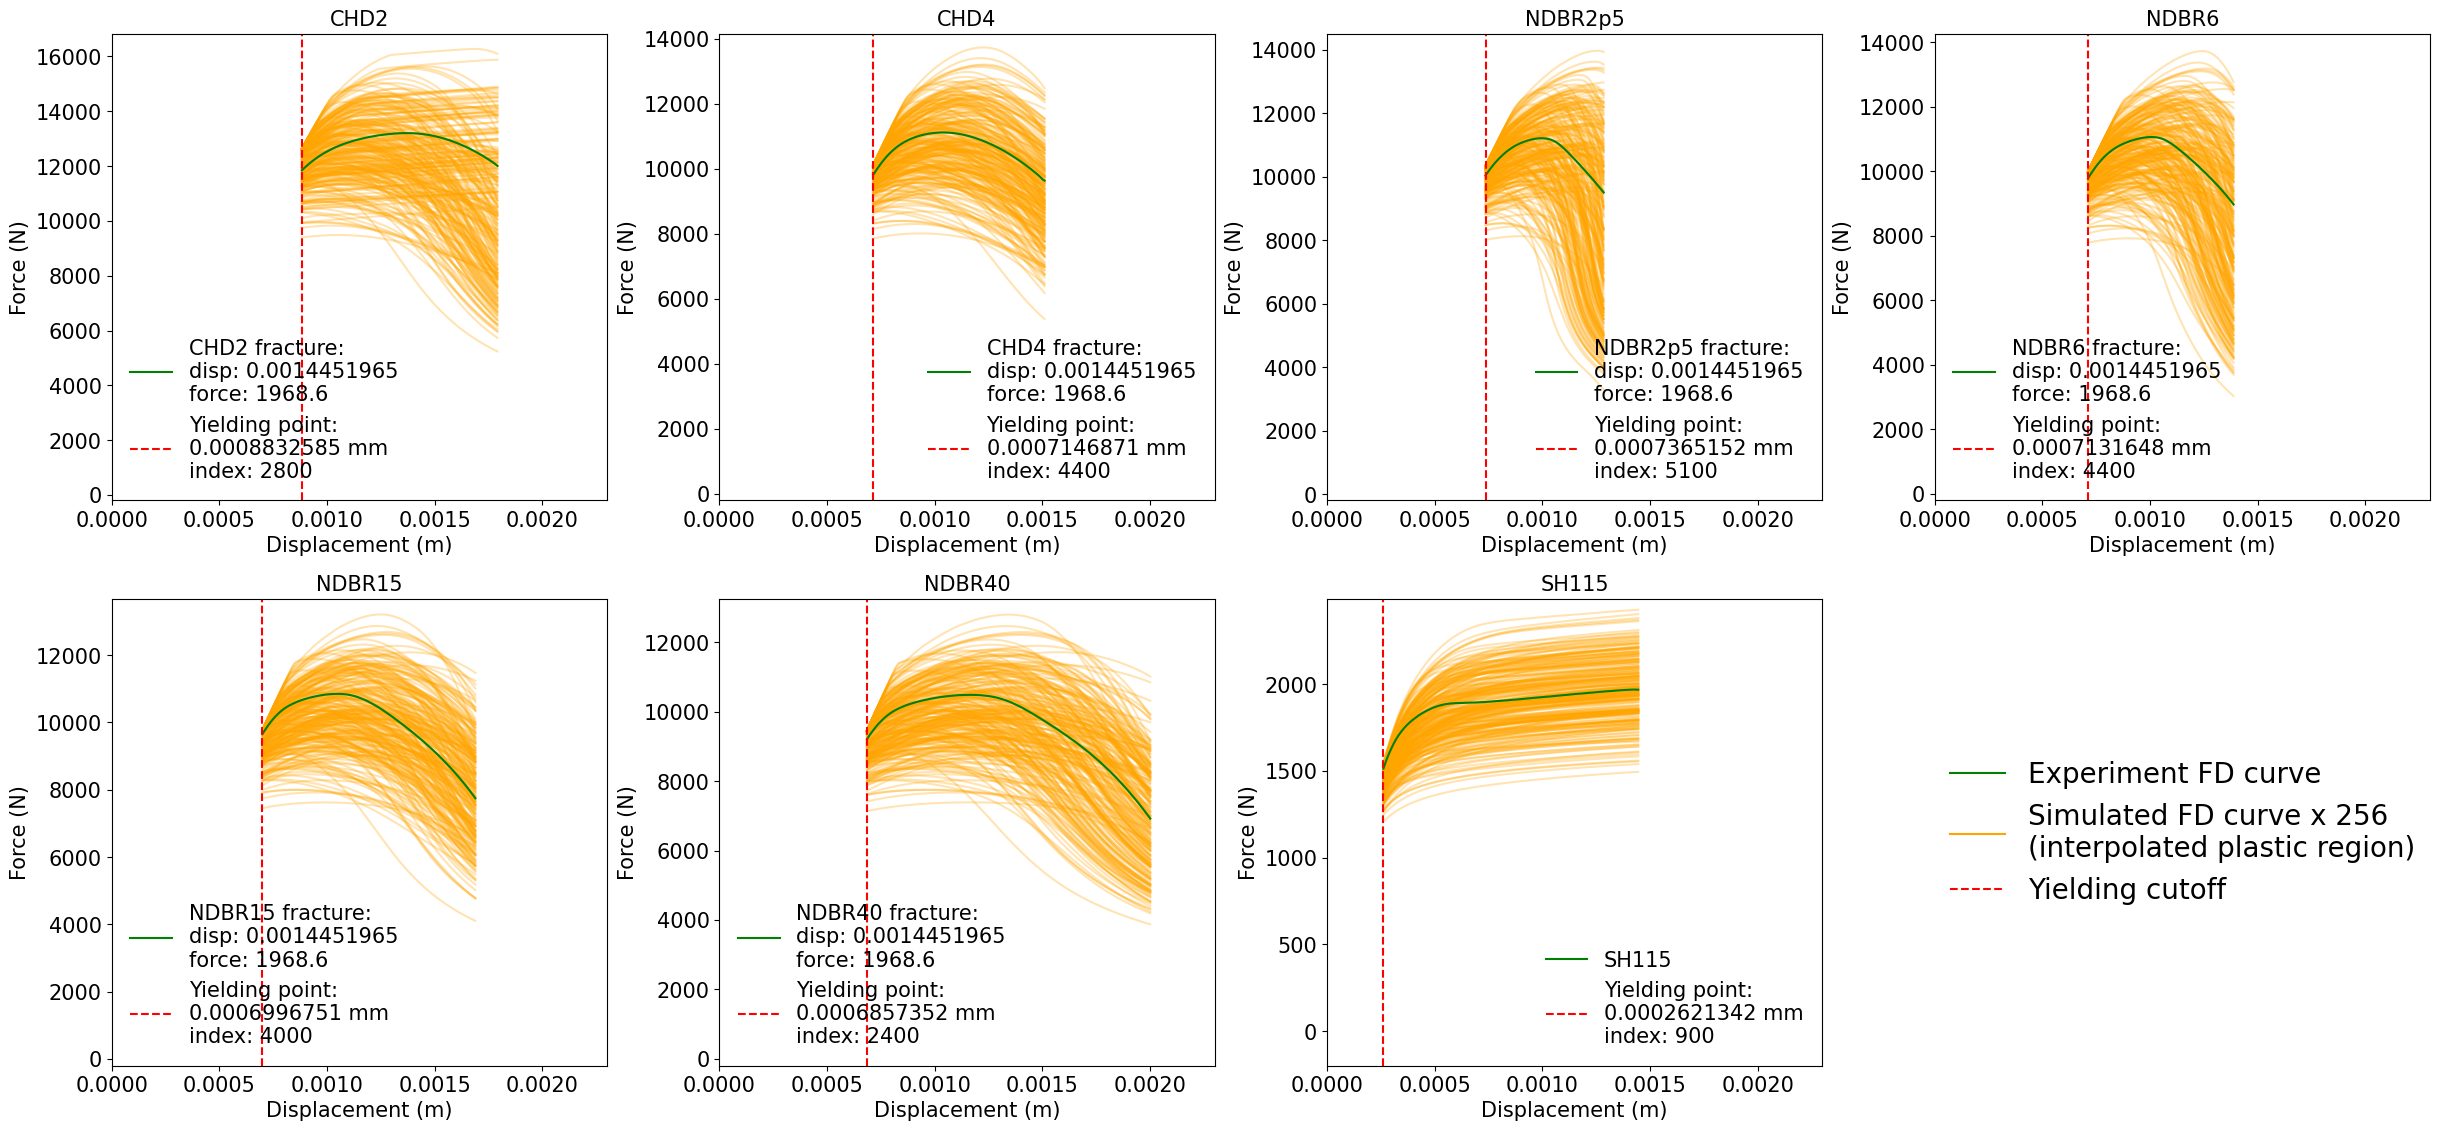

In [26]:
from utils.calculation import interpolating_force

# results_init_common_path = all_paths["results_init_common_path"]
targets_path = all_paths["targets_path"]

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25, 12))
fig.tight_layout(pad=5.0)
ax = ax.ravel()

for i, objective in enumerate(objectives):

    if os.path.exists(f"{results_init_common_path}/{objective}/FD_curves_interpolated.npy"):
        FD_curves_interpolated = np.load(f"{results_init_common_path}/{objective}/FD_curves_interpolated.npy", allow_pickle=True).tolist()
        for params_tuple, FD_curve in FD_curves_interpolated.items():
            sim_interpolated_displacement = FD_curve['displacement'] # displacement is in m
            sim_interpolated_force = FD_curve['force']
            ax[i].plot(sim_interpolated_displacement, sim_interpolated_force, color='orange', alpha=0.3)
    
    # Plotting the mean experimental FD curve
    exp_FD_curve_interpolated = pd.read_excel(f"{targets_path}/{objective}/FD_curve_final_interpolated.xlsx", engine='openpyxl')
    interpolated_exp_displacement = exp_FD_curve_interpolated['displacement/m']
    interpolated_exp_force = exp_FD_curve_interpolated['force/N']
    fracture_disp = round(exp_displacement.iloc[-1], 10)
    fracture_force = round(exp_force.iloc[-1], 1)
    
    if objective != "SH115":
        ax[i].plot(interpolated_exp_displacement, interpolated_exp_force, label=f"{objective} fracture:\ndisp: {fracture_disp}\nforce: {fracture_force}",
               color='green')
    else:
        ax[i].plot(interpolated_exp_displacement, interpolated_exp_force, label=f"{objective}", color='green')
    
    yielding_index = exp_yielding_index[objective]
    ax[i].axvline(x = interpolated_exp_displacement[0], color='r', linestyle='--', 
                  label=f"Yielding point:\n{round(interpolated_exp_displacement[0], 10)} mm\nindex: {yielding_index}")

    ax[i].set_title(f"{objective}", fontsize=15)
    ax[i].set_xlabel("Displacement (m)", fontsize=15)
    ax[i].set_ylabel("Force (N)", fontsize=15)
    ax[i].set_xlim(0, 0.0023)
    ax[i].set_ylim(bottom=-200)
    # ax[i].set_ylim(-500, 17000)
    ax[i].xaxis.set_tick_params(labelsize=15)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].set_xticks([0.0, 0.0005, 0.001, 0.0015, 0.002])
    ax[i].legend(frameon=False, fontsize=15)

ax[7].axis('off')
ax[7].plot([],[],color="green", label="Experiment FD curve", alpha=1)
ax[7].plot([],[],color="orange", label=f"Simulated FD curve x {len(FD_curves_interpolated)}\n(interpolated plastic region)", alpha=1)
ax[7].plot([],[],color="red", label="Yielding cutoff", linestyle='--')
ax[7].legend(frameon=False, fontsize=20,loc='center')

plt.show()

### Final training source sequences for LSTM

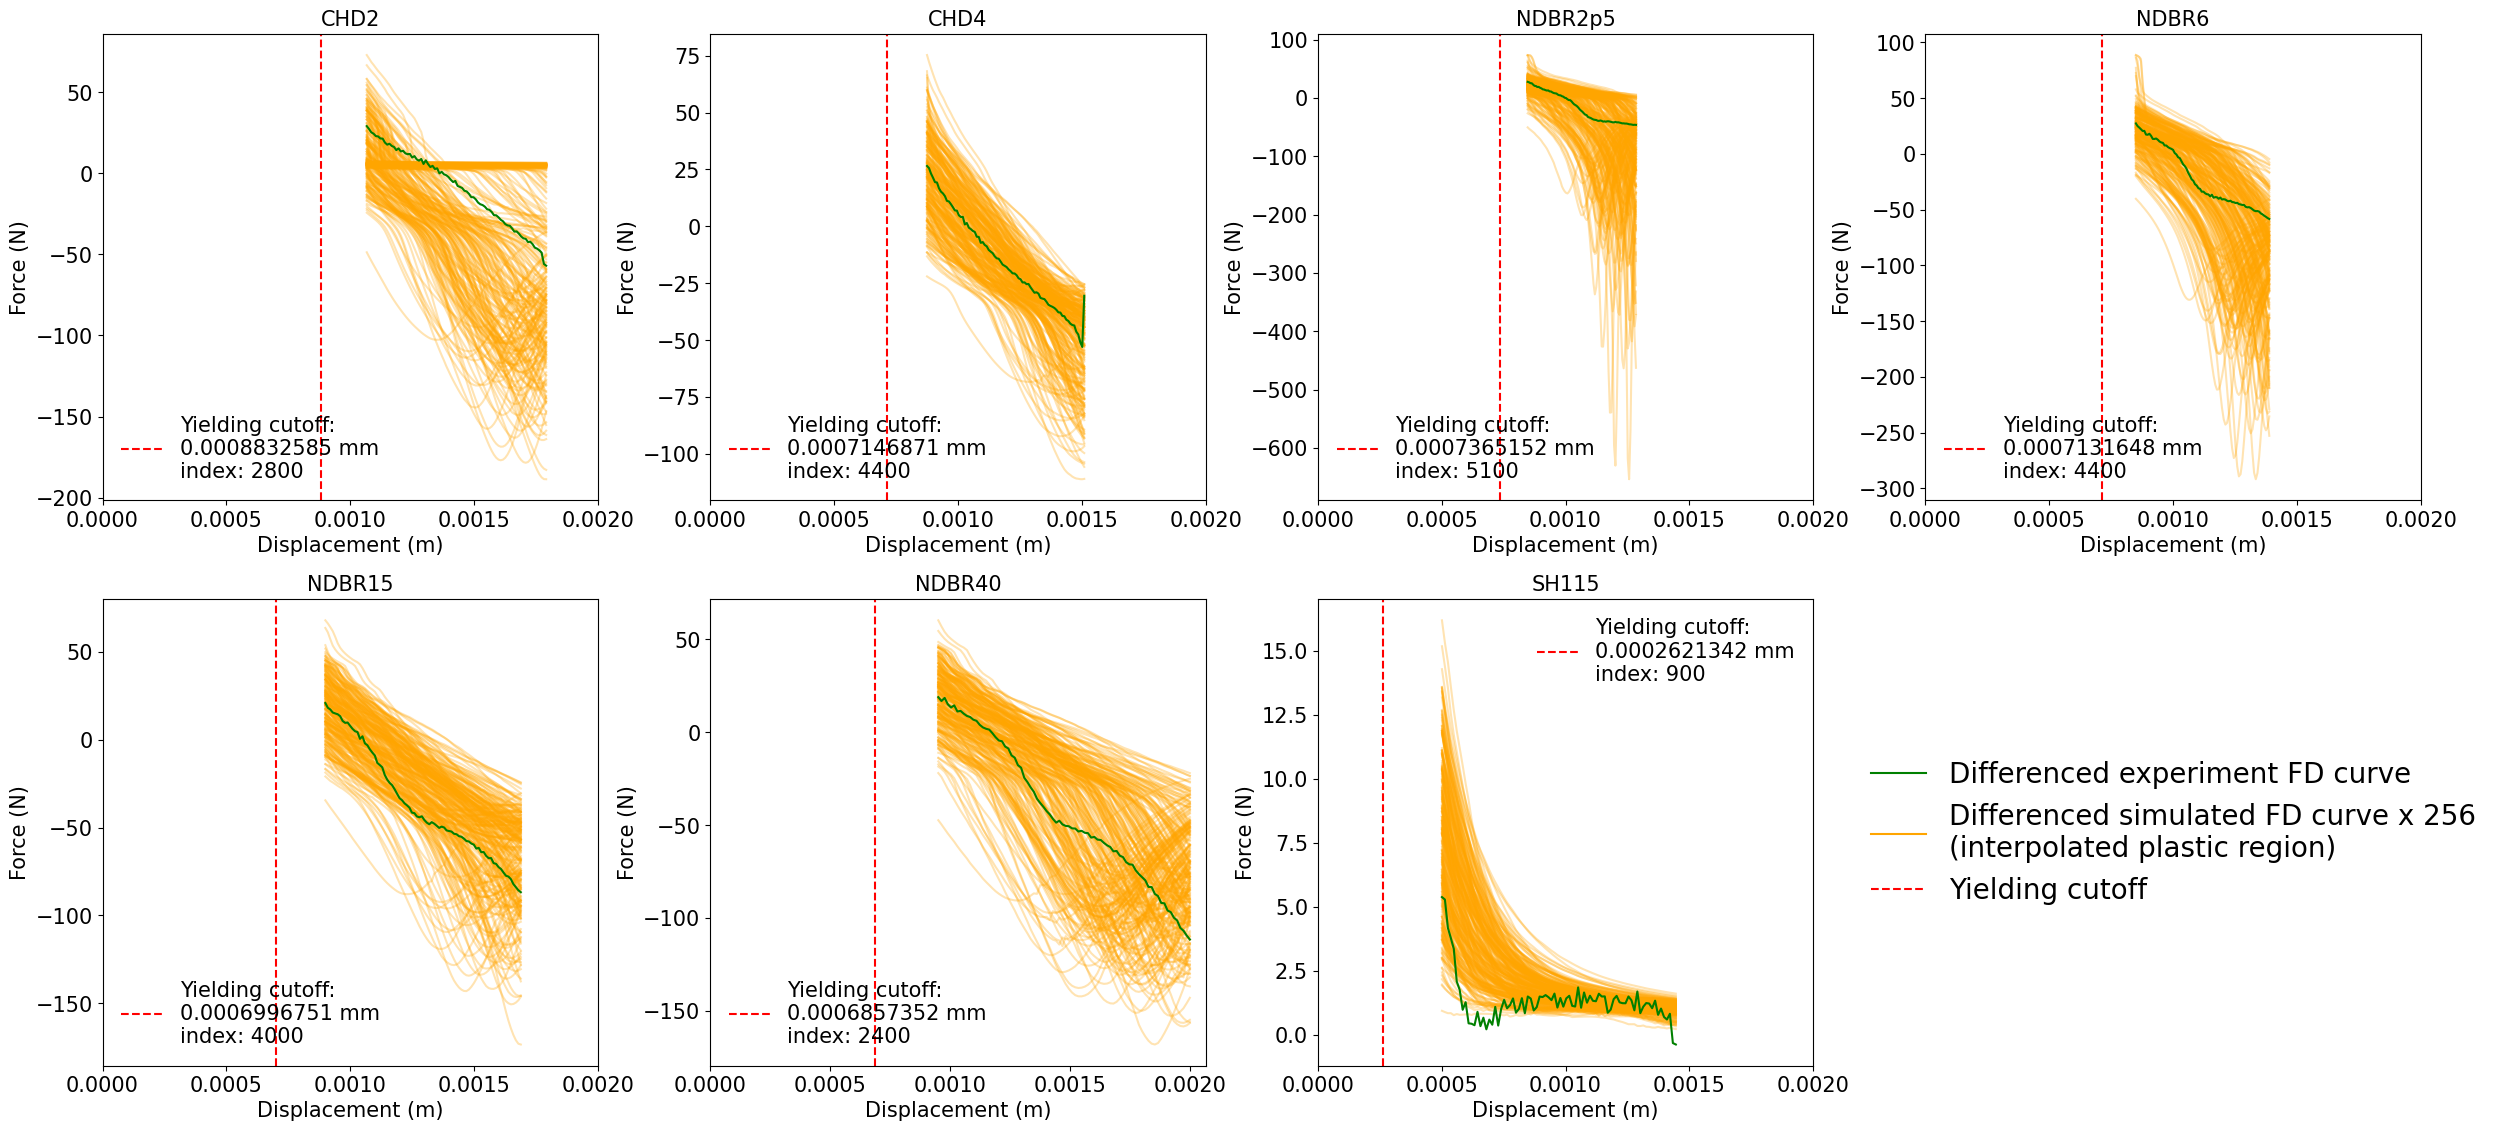

In [27]:
from utils.calculation import interpolating_force

# results_init_common_path = all_paths["results_init_common_path"]
targets_path = all_paths["targets_path"]
model_config = global_configs["model_config"]
divided_index = model_config["divided_index"]

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25, 12))
fig.tight_layout(pad=5.0)
ax = ax.ravel()

for i, objective in enumerate(objectives):

    if os.path.exists(f"{results_init_common_path}/{objective}/FD_curves_interpolated.npy"):
        FD_curves_interpolated = np.load(f"{results_init_common_path}/{objective}/FD_curves_interpolated.npy", allow_pickle=True).tolist()
        for params_tuple, FD_curve in FD_curves_interpolated.items():
            sim_interpolated_displacement = FD_curve['displacement'] # displacement is in m
            sim_interpolated_force = FD_curve['force']
            differenced_sim_interpolated_force = sim_interpolated_force[divided_index+1:] - sim_interpolated_force[divided_index:-1]
            ax[i].plot(sim_interpolated_displacement[divided_index+1:], differenced_sim_interpolated_force, color='orange', alpha=0.3)
            #ax[i].plot(sim_interpolated_displacement, sim_interpolated_force, color='orange', alpha=0.3)
    
    # Plotting the mean experimental FD curve
    exp_FD_curve_interpolated = pd.read_excel(f"{targets_path}/{objective}/FD_curve_final_interpolated.xlsx", engine='openpyxl')
    interpolated_exp_displacement = exp_FD_curve_interpolated['displacement/m'].to_numpy()
    interpolated_exp_force = exp_FD_curve_interpolated['force/N'].to_numpy()
    differenced_interpolated_exp_force = interpolated_exp_force[divided_index+1:] - interpolated_exp_force[divided_index:-1]
    # print(len(interpolated_exp_displacement), len(differenced_interpolated_exp_force))
    
    ax[i].plot(interpolated_exp_displacement[divided_index+1:], differenced_interpolated_exp_force, color='green')
    
    yielding_index = exp_yielding_index[objective]
    ax[i].axvline(x = interpolated_exp_displacement[0], color='r', linestyle='--', 
                  label=f"Yielding cutoff:\n{round(interpolated_exp_displacement[0], 10)} mm\nindex: {yielding_index}")

    ax[i].set_title(f"{objective}", fontsize=15)
    ax[i].set_xlabel("Displacement (m)", fontsize=15)
    ax[i].set_ylabel("Force (N)", fontsize=15)
    #ax[i].set_xlim(0, 0.0023)
    #ax[i].set_ylim(bottom=-200)
    # ax[i].set_ylim(-500, 17000)
    ax[i].xaxis.set_tick_params(labelsize=15)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].set_xticks([0.0, 0.0005, 0.001, 0.0015, 0.002])
    ax[i].legend(frameon=False, fontsize=15)

ax[7].axis('off')
ax[7].plot([],[],color="green", label="Differenced experiment FD curve", alpha=1)
ax[7].plot([],[],color="orange", label=f"Differenced simulated FD curve x {len(FD_curves_interpolated)}\n(interpolated plastic region)", alpha=1)
ax[7].plot([],[],color="red", label="Yielding cutoff", linestyle='--')
ax[7].legend(frameon=False, fontsize=20,loc='center')

plt.show()

### Final training target sequences for LSTM

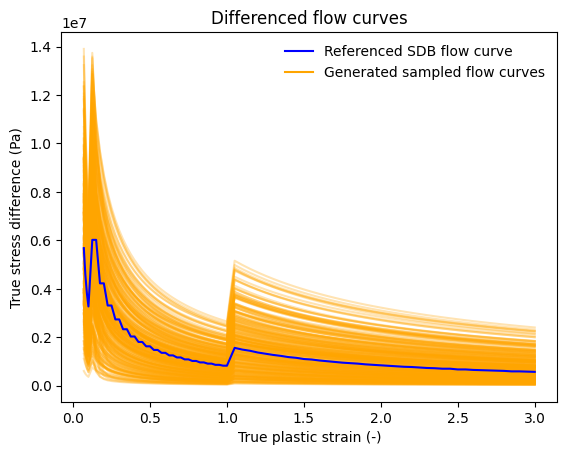

In [34]:
divided_index = model_config["divided_index"]

generated_true_stress = np.load(f"{results_init_common_path}/initial_sampled_true_stress.npy", allow_pickle=True)
true_plastic_strain = np.load(f"{targets_path}/true_plastic_strain.npy", allow_pickle=True)
num_samples = len(generated_true_stress)
generated_diff_true_stress = generated_true_stress[:, divided_index+1:] - generated_true_stress[:, divided_index:-1]


for i in range(num_samples):
    #ax[0].plot(true_plastic_strain, generated_true_stress[i], color="orange", alpha=0.3)
    plt.plot(true_plastic_strain[divided_index+1:], generated_diff_true_stress[i], color="orange", alpha=0.3)

if os.path.exists(f"{targets_path}/referenced_flow_curve_interpolated.csv"):
    referenced_flow_curve_interpolated = pd.read_csv(f"{targets_path}/referenced_flow_curve_interpolated.csv")
    interpolated_referenced_stress_Pa = referenced_flow_curve_interpolated['stress/Pa'].to_numpy()
    interpolated_diff_referenced_stress_Pa = interpolated_referenced_stress_Pa[divided_index+1:] - interpolated_referenced_stress_Pa[divided_index:-1]

    #ax[0].plot(true_plastic_strain, interpolated_referenced_stress_Pa, color="blue", label="Referenced SDB flow curve")
    plt.plot(true_plastic_strain[divided_index+1:], interpolated_diff_referenced_stress_Pa, color="blue", label="Referenced SDB flow curve")

# ax[0].plot([], [], color="orange", label="Generated sampled flow curves")
# ax[0].set_xlabel('True plastic strain (-)')
# ax[0].set_ylabel('True stress (Pa)')
# ax[0].set_xlim(left=-0.1)
# ax[0].set_ylim(bottom=-1e8)
# ax[0].set_title('True stress - true plastic strain curves')
# ax[0].legend(frameon=False)

plt.plot([], [], color="orange", label="Generated sampled flow curves")
plt.xlabel('True plastic strain (-)')
plt.ylabel('True stress difference (Pa)')
plt.title('Differenced flow curves')
plt.legend(frameon=False)

### Final training target sequences for Transformer

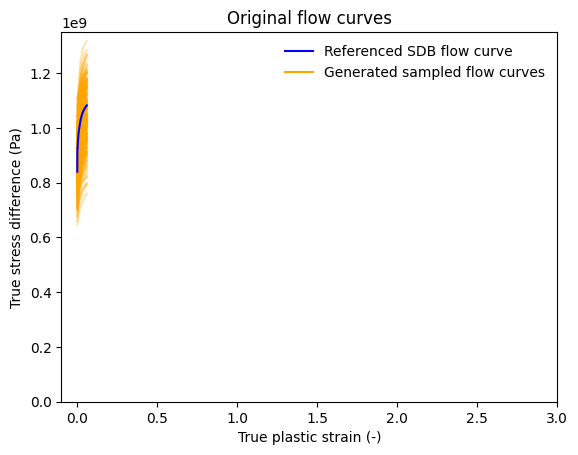

In [33]:
divided_index = model_config["divided_index"]

generated_true_stress = np.load(f"{results_init_common_path}/initial_sampled_true_stress.npy", allow_pickle=True)
true_plastic_strain = np.load(f"{targets_path}/true_plastic_strain.npy", allow_pickle=True)
num_samples = len(generated_true_stress)
generated_diff_true_stress = generated_true_stress[:, divided_index+1:] - generated_true_stress[:, divided_index:-1]


for i in range(num_samples):
    plt.plot(true_plastic_strain[:divided_index+1], generated_true_stress[i][:divided_index+1], color="orange", alpha=0.3)
    
if os.path.exists(f"{targets_path}/referenced_flow_curve_interpolated.csv"):
    referenced_flow_curve_interpolated = pd.read_csv(f"{targets_path}/referenced_flow_curve_interpolated.csv")
    interpolated_referenced_stress_Pa = referenced_flow_curve_interpolated['stress/Pa'].to_numpy()

    plt.plot(true_plastic_strain[:divided_index+1], interpolated_referenced_stress_Pa[:divided_index+1], color="blue", label="Referenced SDB flow curve")

plt.plot([], [], color="orange", label="Generated sampled flow curves")
plt.xlabel('True plastic strain (-)')
plt.ylabel('True stress difference (Pa)')
plt.ylim(bottom=0)
plt.xlim(-0.1,3)
plt.title('Original flow curves')
plt.legend(frameon=False)

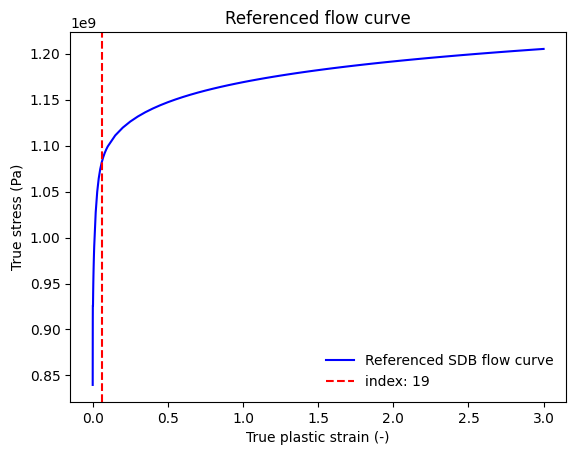

In [31]:
### Plot only the interpolated referenced flow curve

if os.path.exists(f"{targets_path}/referenced_flow_curve.csv"):
    referenced_flow_curve_interpolated = pd.read_csv(f"{targets_path}/referenced_flow_curve.csv")
    interpolated_referenced_stress_Pa = referenced_flow_curve_interpolated['stress/Pa'].to_numpy()
    true_plastic_strain = np.load(f"{targets_path}/true_plastic_strain.npy", allow_pickle=True)

    plt.plot(true_plastic_strain, interpolated_referenced_stress_Pa, color="blue", label="Referenced SDB flow curve")
    
    # Draw a verticle line at the divided index
    plt.axvline(x = true_plastic_strain[divided_index], color='r', linestyle='--', 
                 label= f"index: {divided_index}")
    plt.xlabel('True plastic strain (-)')
    plt.ylabel('True stress (Pa)')
    plt.title('Referenced flow curve')
    plt.legend(frameon=False, loc=4)